In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
import time
import copy
from torchvision import datasets, transforms
from torch import nn, optim
import warnings
warnings.filterwarnings("ignore")
import torchvision.models as models
import torch, torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def transform(my_x, my_y):
    tensor_x = torch.Tensor(my_x) # transform to torch tensor
    tensor_y = torch.LongTensor(my_y)

    my_dataset = data.TensorDataset(tensor_x,tensor_y) # create your datset
    my_dataloader = data.DataLoader(my_dataset) # create your dataloader
    return my_dataloader
    
def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
    logits = resnet18(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [3]:
torch.backends.cudnn.deterministic = True
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
transform = transforms.ToTensor()
batch_size=100

transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.FashionMNIST('fashion-10', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('fashion-10', download=True, train=False, transform=transform)
print(trainset[0][0].shape)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

Extracting fashion-10/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion-10/FashionMNIST/raw


Extracting fashion-10/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion-10/FashionMNIST/raw


Extracting fashion-10/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion-10/FashionMNIST/raw




Extracting fashion-10/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion-10/FashionMNIST/raw
Processing...
Done!
torch.Size([1, 28, 28])


In [4]:
def weigheted_most_common(predictions, weights):
    new_predictions = {}
    for i in range(len(predictions)):
        if predictions[i] in new_predictions:
            new_predictions[predictions[i]] = new_predictions[predictions[i]] + weights[i]
        else:
            new_predictions[predictions[i]] = weights[i]
    top = list(sorted(new_predictions.items(), key=lambda item: item[1], reverse=True))
    return top[0][0]
from collections import Counter
import numpy as np
def ensemble_predictions(members, loader, weights):
    accs = []
    for (X_batch, y_batch) in loader:
        yhats = []
        for model in members:
            y_batch = y_batch.cuda()
            logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
            y_pred = logits.max(1)[1].data
            #print(y_pred.cpu().numpy())
            yhats.append(y_pred.cpu().numpy())
        yhats = np.array(yhats)
        maxs = []
        for i in range(yhats.shape[1]):
            cur_max = weigheted_most_common(yhats[:, i], weights)
            maxs.append(cur_max)
        # sum across ensemble members
        maxs = np.array(maxs)
        # argmax across classes
        accs.append(np.mean((y_batch.cpu().numpy() == maxs)))
    accs = np.array(accs)
    return accs, np.mean(accs)

In [5]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [6]:
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1. #* math.exp(-x * 0.1)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [ ]:
import time
import copy

resnet18 = ResNet(BasicBlock, [2,2,2,2]) #models.resnet18(num_classes=10, pretrained=False)
cnt = 0
for el in resnet18.parameters():
    cnt += 1
print(cnt)
resnet18 = resnet18.cuda()

num_epochs = 21
start_lr = 0.1
end_lr = 1
factor = 10
opt = torch.optim.Adam(resnet18.parameters(), lr=end_lr)


step_size = 1*len(trainset) / batch_size
print(step_size)
clr = cyclical_lr(step_size, min_lr=start_lr, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

models_list = []
weight_list = []


train_loss = []
val_accuracy = []
losses = []
accs = []

lr_find_loss = []
learning_rates = []

it = 0

smoothing = 0.5
small_flag = False
lrs = []

for epoch in range(num_epochs):
    start_time = time.time()
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.cpu().numpy())
      

        scheduler.step()
        opt.zero_grad()

        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        learning_rates.append(lr_step)
        lr_find_loss.append(loss)
        if lr_step <= 0.103:
            print('add minimun')
            models_list.append(copy.deepcopy(resnet18))
            weight_list.append(10.)
        elif lr_step <= 0.502 and lr_step > 0.499:
            print('add not minimum')
            models_list.append(copy.deepcopy(resnet18))
            weight_list.append(1.)
        if len(models_list) > 25:
          models_list = models_list[-25:]
        it += 1
        

    resnet18.train(False)
    for (X_batch, y_batch) in testloader:
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
    
    accs.append(np.mean(val_accuracy[-len(testset) // batch_size :]))
    cur_loss = np.mean(train_loss[-len(trainset) // batch_size :])


    
    if epoch % 10 == 0:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(trainset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(testset) // batch_size :]) * 100))
    losses.append(np.array(train_loss).mean())

62
600.0
add minimun
add not minimum
Epoch 1 of 21 took 64.084s
  training loss (in-iteration): 	1.019888
  validation accuracy: 			79.39 %
add not minimum
add minimun
add minimun
add minimun
add not minimum
add not minimum
add minimun
add minimun
add minimun
add minimun
add not minimum
add not minimum
add not minimum
add not minimum
add minimun
add minimun
add minimun
add minimun
add minimun
add not minimum
add not minimum
add not minimum
add not minimum
add minimun
add minimun
add minimun
add minimun
add not minimum
add not minimum
add minimun
add minimun
add minimun
add not minimum
Epoch 11 of 21 took 67.832s
  training loss (in-iteration): 	0.471674
  validation accuracy: 			69.44 %
add not minimum
add minimun
add minimun
add minimun
add not minimum
add not minimum
add minimun
add minimun
add minimun
add not minimum
add not minimum
add minimun
add minimun
add minimun
add not minimum
add not minimum
add not minimum
add not minimum
add minimun
add minimun
add minimun
add not minimum


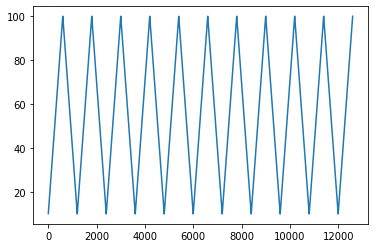

In [ ]:
plt.plot(list(range(len(learning_rates))), (np.array(learning_rates) * 100))
plt.show()

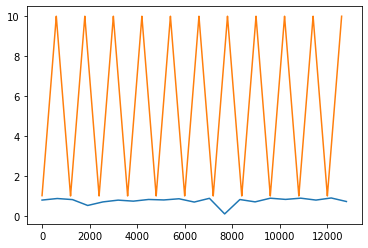

In [ ]:
plt.plot(np.array(list(range(len(accs)))) * 640, accs)
plt.plot(list(range(len(learning_rates))), (np.array(learning_rates) * 10))
plt.show()

In [ ]:
weight_list = weight_list[-25:]

In [ ]:
old_models = models_list
old_weights = weight_list

In [ ]:
# finding optimal good weight:
bad_weight = np.logspace(-5, 0, num=11)
def make_new_weights(weights, good, bad):
    new_weights = []
    for i in range(len(weights)):
        if weights[i] > 2.:
            new_weights.append(good)
        else:
            new_weights.append(bad)
    new_weights = np.array(weights)
    sums = new_weights.sum()
    new_weights = new_weights/sums
    return new_weights

accs_list = []
for w in bad_weight:
    new_weights = make_new_weights(weight_list, 1-w, w)
    mean = 0.
    for i in range(3):
        accs, mean_accs = ensemble_predictions(models_list, testloader, new_weights)
        mean += mean_accs
    mean /= 3.
    accs_list.append(mean)
    print(w, round(mean_accs, 3) * 100, '%')

1e-05 89.2 %
3.1622776601683795e-05 89.2 %
0.0001 89.1 %
0.00031622776601683794 89.2 %
0.001 89.1 %
0.0031622776601683794 89.1 %
0.01 89.0 %
0.03162277660168379 89.2 %
0.1 89.4 %
0.31622776601683794 89.0 %
1.0 89.1 %


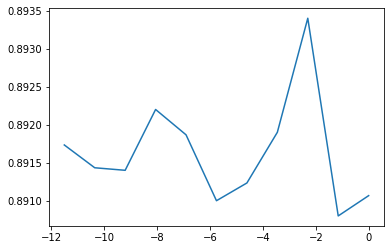

In [ ]:
#big lr
import matplotlib.pyplot as plt
plt.plot(np.log(bad_weight), accs_list)
plt.show()

In [ ]:
#big lr
for model in models_list:
  accuracy = []
  for (X_batch, y_batch) in testloader:
          y_batch = y_batch.cuda()
          logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
          y_pred = logits.max(1)[1].data
          accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
  print(np.array(accuracy).mean() * 100, '%')

75.17000000000002 %
81.97 %
81.95 %
82.3 %
80.39 %
84.42 %
88.58000000000001 %
88.47000000000001 %
88.45 %
84.46 %
84.83999999999999 %
86.50999999999999 %
87.2 %
88.77000000000001 %
88.73999999999998 %
88.59 %
87.54 %
87.56000000000002 %
89.07 %
89.21 %
89.91000000000001 %
89.77 %
89.75 %
88.25 %
88.54999999999998 %


In [7]:
import time
import copy

resnet18 = ResNet(BasicBlock, [2,2,2,2]) #models.resnet18(num_classes=10, pretrained=False)
cnt = 0
for el in resnet18.parameters():
    cnt += 1
print(cnt)
resnet18 = resnet18.cuda()

num_epochs = 21
start_lr = 0.01
end_lr = 0.1
factor = 10
opt = torch.optim.Adam(resnet18.parameters(), lr=end_lr)


step_size = 1*len(trainset) / batch_size
print(step_size)
clr = cyclical_lr(step_size, min_lr=start_lr, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

models_list = []
weight_list = []


train_loss = []
val_accuracy = []
losses = []
accs = []

lr_find_loss = []
learning_rates = []

it = 0

smoothing = 0.5
small_flag = False
lrs = []

for epoch in range(num_epochs):
    start_time = time.time()
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        train_loss.append(loss.data.cpu().numpy())
      

        scheduler.step()
        opt.zero_grad()

        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        learning_rates.append(lr_step)
        #print(lr_step)
        lr_find_loss.append(loss)
        if lr_step <= 0.00103:
            print('add minimun')
            models_list.append(copy.deepcopy(resnet18))
            weight_list.append(10.)
        elif lr_step <= 0.00502 and lr_step > 0.00499:
            print('add not minimum')
            models_list.append(copy.deepcopy(resnet18))
            weight_list.append(1.)
        if len(models_list) > 25:
          models_list = models_list[-25:]
        it += 1
        

    resnet18.train(False)
    for (X_batch, y_batch) in testloader:
        y_batch = y_batch.cuda()
        logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
        y_pred = logits.max(1)[1].data
        val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
    
    accs.append(np.mean(val_accuracy[-len(testset) // batch_size :]))
    cur_loss = np.mean(train_loss[-len(trainset) // batch_size :])


    
    if epoch % 10 == 0:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(trainset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(testset) // batch_size :]) * 100))
    losses.append(np.array(train_loss).mean())

62
600.0
add minimun
add not minimum
add not minimum
Epoch 1 of 21 took 45.601s
  training loss (in-iteration): 	0.432628
  validation accuracy: 			88.69 %
add not minimum
add not minimum
add minimun
add minimun
add minimun
add not minimum
add not minimum
add not minimum
add not minimum
add minimun
add minimun
add minimun
add minimun
add not minimum
add not minimum
add not minimum
add not minimum
add not minimum
add not minimum
add minimun
add minimun
add minimun
add minimun
add minimun
add not minimum
add not minimum
add not minimum
add not minimum
add not minimum
add not minimum
add minimun
add minimun
add minimun
add minimun
add not minimum
add not minimum
add not minimum
add not minimum
add minimun
add minimun
add minimun
add not minimum
add not minimum
Epoch 11 of 21 took 45.505s
  training loss (in-iteration): 	0.061106
  validation accuracy: 			91.51 %
add not minimum
add not minimum
add minimun
add minimun
add minimun
add not minimum
add not minimum
add not minimum
add not mini

In [8]:
# finding optimal good weight:
bad_weight = np.logspace(-5, 0, num=11)
def make_new_weights(weights, good, bad):
    new_weights = []
    for i in range(len(weights)):
        if weights[i] > 2.:
            new_weights.append(good)
        else:
            new_weights.append(bad)
    new_weights = np.array(weights)
    sums = new_weights.sum()
    new_weights = new_weights/sums
    return new_weights

accs_list = []
for w in bad_weight:
    new_weights = make_new_weights(weight_list, 1-w, w)
    mean = 0.
    for i in range(3):
        accs, mean_accs = ensemble_predictions(models_list, testloader, new_weights)
        mean += mean_accs
    mean /= 3.
    accs_list.append(mean)
    print(w, round(mean_accs, 3) * 100, '%')

1e-05 94.0 %
3.1622776601683795e-05 94.0 %
0.0001 94.19999999999999 %
0.00031622776601683794 94.0 %
0.001 94.0 %
0.0031622776601683794 94.0 %
0.01 94.19999999999999 %
0.03162277660168379 93.89999999999999 %
0.1 94.0 %
0.31622776601683794 94.19999999999999 %
1.0 94.0 %


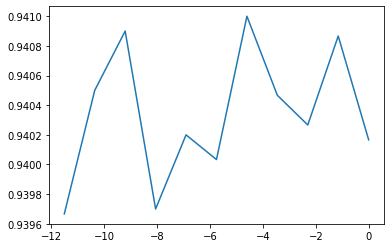

In [9]:
#small lr
import matplotlib.pyplot as plt
plt.plot(np.log(bad_weight), accs_list)
plt.show()

In [10]:
#small lr
for model in models_list:
  accuracy = []
  for (X_batch, y_batch) in testloader:
          y_batch = y_batch.cuda()
          logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
          y_pred = logits.max(1)[1].data
          accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
  print(np.array(accuracy).mean() * 100, '%')

93.83999999999999 %
93.77 %
93.97999999999998 %
94.02 %
93.03999999999999 %
93.01 %
93.93 %
93.90999999999998 %
94.08999999999997 %
93.91 %
93.8 %
93.03 %
93.11 %
93.67 %
93.71999999999998 %
93.74 %
93.67000000000002 %
93.55 %
93.45 %
93.33 %
93.6 %
93.52999999999999 %
93.66 %
93.80000000000001 %
93.64999999999999 %


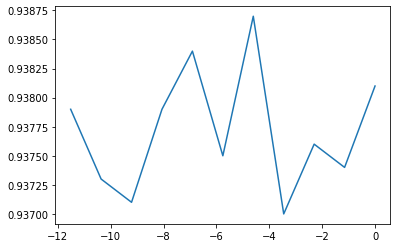

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.log(bad_weight), accs_list)
plt.show()

In [ ]:
#weight_list
bad_weight = np.arange(0, 11) * 100
good_weight = np.arange(1, 11) * 100
print(bad_weight)
def make_new_weights(weights, good, bad):
    new_weights = []
    for i in range(len(weights)):
        if weights[i] > 2.:
            new_weights.append(good)
        else:
            new_weights.append(bad)
    new_weights = np.array(weights)
    sums = new_weights.sum()
    new_weights = new_weights/sums
    return new_weights

accs_map = np.zeros((len(good_weight), len(bad_weight)))
for i in range(len(good_weight)):
    for j in range(len(bad_weight)):
        new_weights = make_new_weights(weight_list, good_weight[i], bad_weight[j])
        accs, mean_accs = ensemble_predictions(models_list, testloader, new_weights)
        accs_map[i, j] = mean_accs
        print(i, j, round(mean_accs, 3) * 100, '%')

[   0  100  200  300  400  500  600  700  800  900 1000]
0 0 93.30000000000001 %
0 1 93.10000000000001 %
0 2 93.2 %
0 3 93.2 %
0 4 93.30000000000001 %
0 5 93.30000000000001 %
0 6 93.30000000000001 %
0 7 93.30000000000001 %
0 8 93.2 %
0 9 93.2 %
0 10 93.2 %
1 0 93.2 %


KeyboardInterrupt: ignored

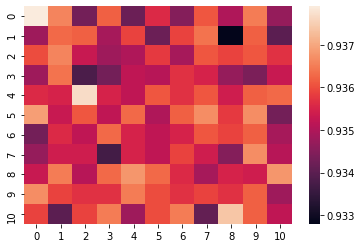

In [ ]:
from seaborn import heatmap
heatmap(accs_map) #x -- good, y -- bad

In [ ]:
bad_weight = np.logspace(0, 3, num=11)
good_weight = np.logspace(0, 3, num=11)
print(bad_weight)

accs_map = np.zeros((len(good_weight), len(bad_weight)))
for i in range(len(good_weight)):
    for j in range(len(bad_weight)):
        new_weights = make_new_weights(weight_list, good_weight[i], bad_weight[j])
        accs, mean_accs = ensemble_predictions(models_list, testloader, new_weights)
        accs_map[i, j] = mean_accs
        print(i, j, round(mean_accs, 3) * 100, '%')

[   1.            1.99526231    3.98107171    7.94328235   15.84893192
   31.6227766    63.09573445  125.89254118  251.18864315  501.18723363
 1000.        ]
0 0 93.5 %
0 1 93.4 %
0 2 93.60000000000001 %
0 3 93.60000000000001 %
0 4 93.5 %
0 5 93.7 %
0 6 93.5 %
0 7 93.7 %
0 8 93.7 %
0 9 93.60000000000001 %
0 10 93.5 %
1 0 93.60000000000001 %
1 1 93.5 %
1 2 93.60000000000001 %
1 3 93.60000000000001 %
1 4 93.60000000000001 %
1 5 93.60000000000001 %
1 6 93.7 %
1 7 93.60000000000001 %
1 8 93.60000000000001 %
1 9 93.4 %
1 10 93.5 %
2 0 93.60000000000001 %
2 1 93.60000000000001 %
2 2 93.5 %
2 3 93.5 %
2 4 93.5 %
2 5 93.60000000000001 %
2 6 93.7 %
2 7 93.5 %
2 8 93.7 %
2 9 93.5 %
2 10 93.60000000000001 %
3 0 93.60000000000001 %
3 1 93.60000000000001 %
3 2 93.60000000000001 %
3 3 93.60000000000001 %
3 4 93.60000000000001 %
3 5 93.5 %
3 6 93.60000000000001 %
3 7 93.60000000000001 %
3 8 93.5 %
3 9 93.60000000000001 %
3 10 93.60000000000001 %
4 0 93.60000000000001 %
4 1 93.5 %
4 2 93.6000000000000

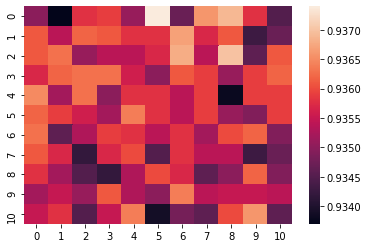

In [ ]:
from seaborn import heatmap
heatmap(accs_map) #log plot